# 1D wavefunction propagation examples

This notebook contains various examples of 1D wavefunction propagation.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
from matplotlib.colors import rgb_to_hsv
from matplotlib.colors import hsv_to_rgb
# from matplotlib.colors import rgb_to_lab
# from matplotlib.colors import lab_to_rgb

# from skimage import color
# import ipywidgets as widgets
# from IPython.display import HTML

# Define various functions for 1D wavefunction propagation examples
def color_complex(
    exit_wave, 
    amp_range=(0,1.0), 
    amp_power=1, 
    ):
    """
    Generate a colored image from a complex exit wave.

    Inputs:
        exit_wave  - 2D complex number array
        amp_range - min and max amplitude
    Outputs:
        im_rgb    - RGB output image
    
    """
    
    pha = np.angle(exit_wave)
    amp = np.abs(exit_wave)
    amp = np.clip((amp - amp_range[0]) / (amp_range[1] - amp_range[0]), 0, 1)
    if amp_power != 1:
        amp = amp ** amp_power

        
    # Generate blue-corrected hue colormap
    num_colors = 256
    t = np.linspace(0,1,num_colors)
    cmap = cm.hsv(t)
    # cmap = rgb_to_hsv(cmap[:,0:3])
    # c_scale = np.sin(np.maximum(1 - 3*np.abs(t - 0.667),0)*(np.pi/2))**2
    # cmap[:,1] = cmap[:,1] - 0.5 * c_scale
    # cmap = hsv_to_rgb(cmap)
    
    # Generate image
    im_rgb = np.ones((exit_wave.shape[0],exit_wave.shape[1],3))
    im_rgb[:,:,0] = np.mod(pha/(2*np.pi) + 0.5,1)
    im_rgb[:,:,2] =  amp
 
    # correct blue values from hue map
    c_scale = np.sin(np.maximum(1 - 6*np.abs(im_rgb[:,:,0] - 0.667),0)*(np.pi/2))**2
    im_rgb[:,:,1] = im_rgb[:,:,1]*(1 - 0.333*c_scale)
    im_rgb[:,:,2] = im_rgb[:,:,2]*(1 + 0.333*c_scale)
    
    # correct green values (and lime-green / yellow)
    c_scale = np.sin(np.maximum(1 - 4*np.abs(im_rgb[:,:,0] - 0.333),0)*(np.pi/2))**2
    im_rgb[:,:,2] = im_rgb[:,:,2]*(1 - 0.167*c_scale)      
   
    # Output image
    im_rgb[:,:,2] = np.clip(im_rgb[:,:,2], 0, 1)
    im_rgb = hsv_to_rgb(im_rgb)
  
    return im_rgb


def wavefunction_prop(
    pot,
    psi=None,
    slice_thickness = 1.0,
    pixel_size = 0.1,
    wavelength = 0.02,
    band_limit = 0.25,
    normalize_rows_mean = False,
    normalize_rows_max = False,
    ):
    """
    This function propagates a wavefunction vertically from the top row through the image array pot.
    If no psi wavefunction is specified, we assume plane wave initial condition.
    
    Inputs:
        
    Outputs:
        
    
    """    
    
    # coords
    q = np.fft.fftfreq(pot.shape[1],pixel_size)
    prop = np.exp((-1*1j*np.pi*wavelength*slice_thickness)*q**2)
    
    # band limit
    q = np.fft.fftfreq(pot.shape[1], 1.0)
    prop = prop * (np.abs(q) < band_limit)
    
    # initial wavefunction if needed
    if psi is None:
        psi = np.ones(pot.shape[1], dtype='complex')
    else:
        psi = psi.astype('complex')
        
    # init output
    psi_all = np.zeros(pot.shape, dtype='complex')
    
    # Loop over all rows
    for a0 in range(pot.shape[0]):
        psi = np.fft.ifft(np.fft.fft(psi) * prop) * pot[a0,:]
        
        if normalize_rows_mean:
            psi_all[a0,:] = psi / np.mean(np.abs(psi))
        elif normalize_rows_max:
            psi_all[a0,:] = psi / np.max(np.abs(psi))        
        else:
            psi_all[a0,:] = psi
    
    return psi_all


def make_diffraction_grating(
    image_size = (256,384),
    vert_range = (16,20),
    gap_num = 2,
    gap_size = 8,
    gap_spacing = 32,
    ):
    """
    This function makes a complex potential image representing a diffraction grating.
    
    Inputs:
        
    Outputs:
        
    
    """
    
    # init
    pot = np.ones(image_size)
    pot[vert_range[0]:vert_range[1],:] = 0

    # Add gaps
    g = np.arange(gap_num)
    g = (g - np.mean(g)) * gap_spacing + image_size[1]/2
    for a0 in range(gap_num):
        pot[vert_range[0]:vert_range[1],
            np.round((g[a0] - gap_size/2)).astype('int'):(np.round(g[a0] + gap_size/2)).astype('int')] = 1
    
    return pot


def make_phase_wedge(
    image_size = (256,384),
    phase_shift=np.pi/2,
    wedge_width=256,
    wedge_height=128,
    wedge_pos=None,
    ):
    """
    This function makes a complex potential image representing a phase wedge.  Default position is the middle of the cell
    
    Inputs:
        
    Outputs:
        
    
    """

    # init
    pot = np.ones(image_size, dtype='complex')
    p = np.exp(1j*phase_shift)
    
    # position of the wedge
    if wedge_pos is None:
        wedge_pos = np.array(image_size) / 2
    x_inds = np.arange(wedge_height)
    x_inds = np.round(wedge_pos[0] - wedge_height/2 + x_inds).astype('int')
    y1 = np.round(wedge_pos[1] + wedge_width/2).astype('int')
    
    for a0 in range(wedge_height):
        y0 = np.round(wedge_pos[1] - wedge_width/2 + a0/wedge_height*wedge_width).astype('int') 
        pot[x_inds[a0],y0:y1] = p
        
    return pot


def STEM_probe(
    wavefunction_size = 384,
    probe_max_inv_ang = 1,
    pixel_size = 0.1,
    probe_pos = None,
    ):
    """
    This function generates a STEM probe.  Default position is middle of the cell.
    
    Inputs:
        
    Outputs:
        
    
    """
        
    # coords
    q = np.fft.fftfreq(wavefunction_size, pixel_size)
    psi = (np.abs(q) <= probe_max_inv_ang).astype('complex')
    
    # probe shift
    if probe_pos is None:
        probe_pos = wavefunction_size * pixel_size * 0.5
    psi = psi * np.exp((-2j*np.pi*probe_pos)*q)
        
    # Realspace
    psi = np.fft.ifft(psi)
        
    return psi
    

def plot_image(im_rgb):
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    ax.imshow(
        im_rgb,
        )
    ax.axis("off")
    plt.show()

### STEM probe + phase wedge

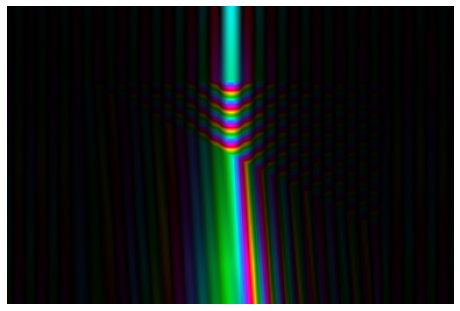

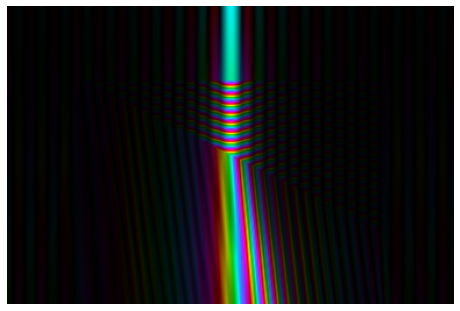

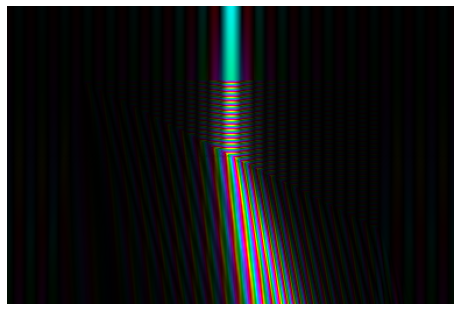

In [2]:
plot_image(color_complex(wavefunction_prop(
    make_phase_wedge(phase_shift=np.pi/8),
    STEM_probe(probe_max_inv_ang=0.5),
    normalize_rows_max=True)))
plot_image(color_complex(wavefunction_prop(
    make_phase_wedge(phase_shift=np.pi/4),
    STEM_probe(probe_max_inv_ang=0.5),
    normalize_rows_max=True)))
plot_image(color_complex(wavefunction_prop(
    make_phase_wedge(phase_shift=np.pi/2),
    STEM_probe(probe_max_inv_ang=0.5),
    normalize_rows_max=True)))

### STEM probes

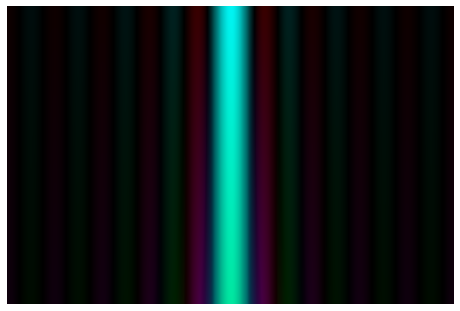

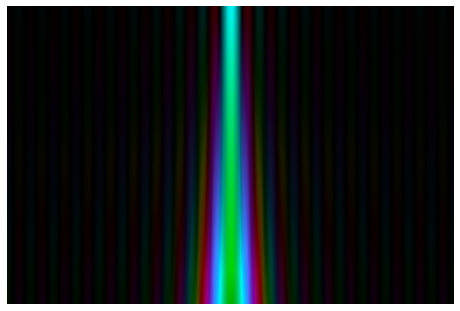

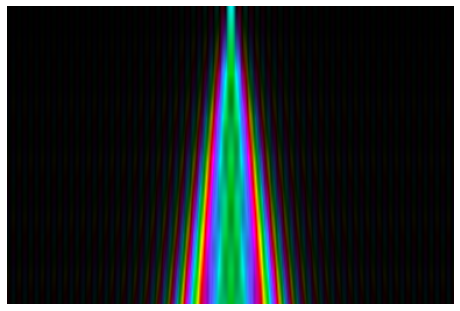

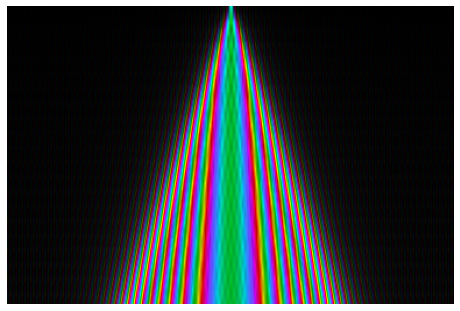

In [3]:
plot_image(color_complex(wavefunction_prop(
    np.ones((256,384)),
    STEM_probe(probe_max_inv_ang=0.25),
    normalize_rows_max=True)))

plot_image(color_complex(wavefunction_prop(
    np.ones((256,384)),
    STEM_probe(probe_max_inv_ang=0.5),
    normalize_rows_max=True)))

plot_image(color_complex(wavefunction_prop(
    np.ones((256,384)),
    STEM_probe(probe_max_inv_ang=1.0),
    normalize_rows_max=True)))

plot_image(color_complex(wavefunction_prop(
    np.ones((256,384)),
    STEM_probe(probe_max_inv_ang=2.0),
    normalize_rows_max=True)))

### Single slit example

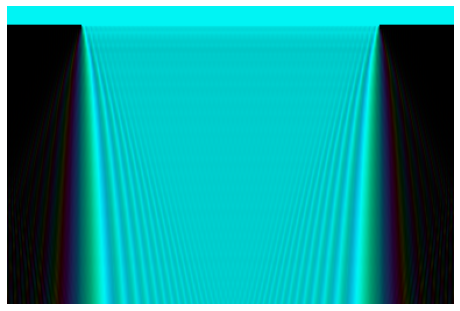

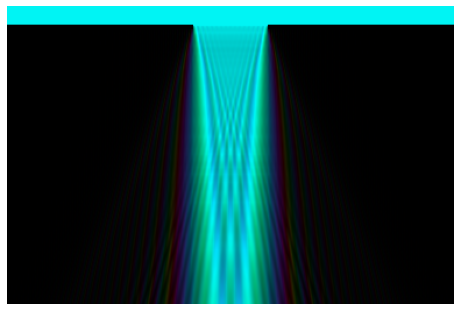

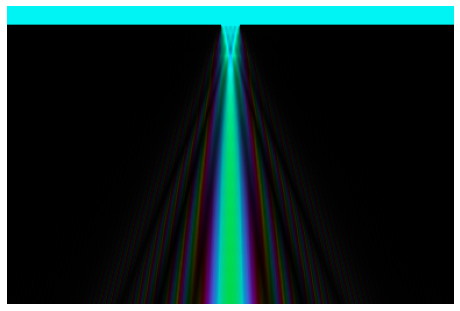

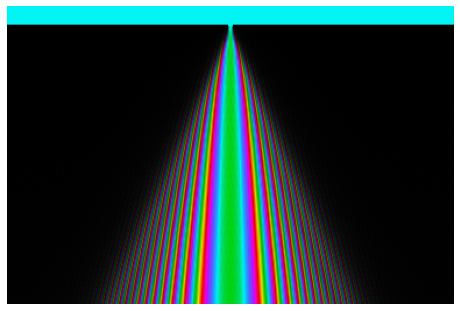

In [4]:
plot_image(color_complex(wavefunction_prop(
    make_diffraction_grating(gap_num=1, gap_size = 256),
    normalize_rows_max=True)))

plot_image(color_complex(wavefunction_prop(
    make_diffraction_grating(gap_num=1, gap_size = 64),
    normalize_rows_max=True)))

plot_image(color_complex(wavefunction_prop(
    make_diffraction_grating(gap_num=1, gap_size = 16),
    normalize_rows_max=True)))

plot_image(color_complex(wavefunction_prop(
    make_diffraction_grating(gap_num=1, gap_size = 4),
    normalize_rows_max=True)))

### Two slit example

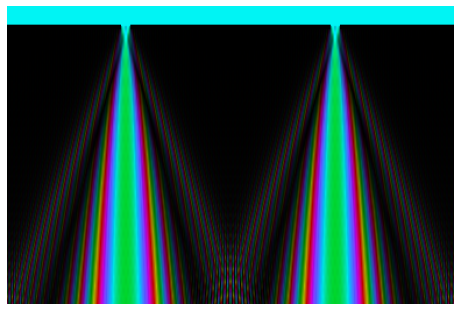

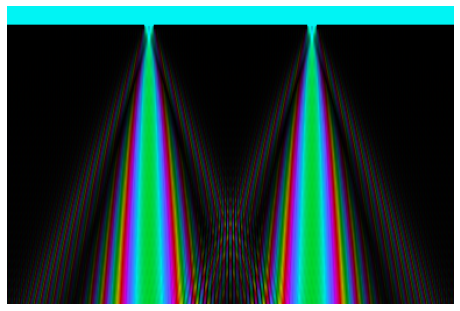

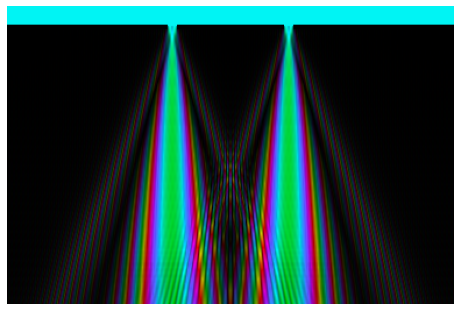

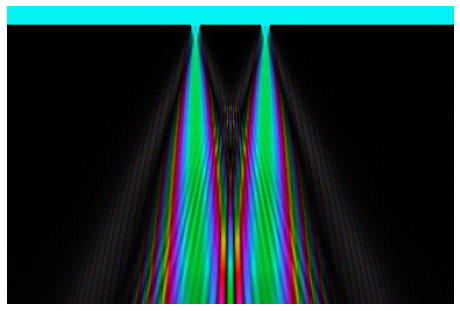

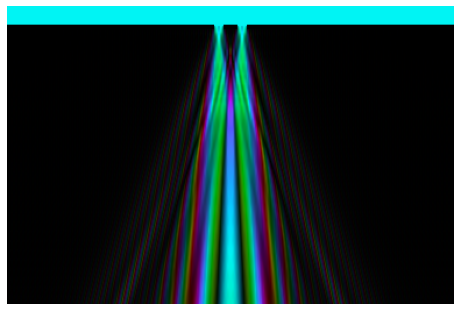

In [5]:
# slit spacing example
plot_image(color_complex(wavefunction_prop(
    make_diffraction_grating(gap_spacing = 180),
    normalize_rows_max=True)))

plot_image(color_complex(wavefunction_prop(
    make_diffraction_grating(gap_spacing = 140),
    normalize_rows_max=True)))

plot_image(color_complex(wavefunction_prop(
    make_diffraction_grating(gap_spacing = 100),
    normalize_rows_max=True)))

plot_image(color_complex(wavefunction_prop(
    make_diffraction_grating(gap_spacing = 60),
    normalize_rows_max=True)))

plot_image(color_complex(wavefunction_prop(
    make_diffraction_grating(gap_spacing = 20),
    normalize_rows_max=True)))

### Many gap example

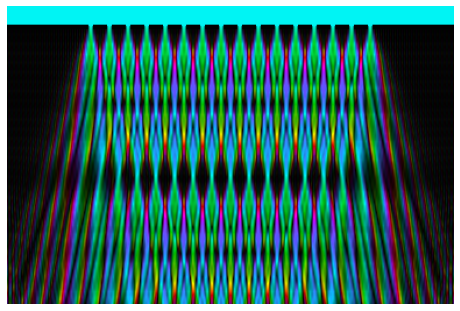

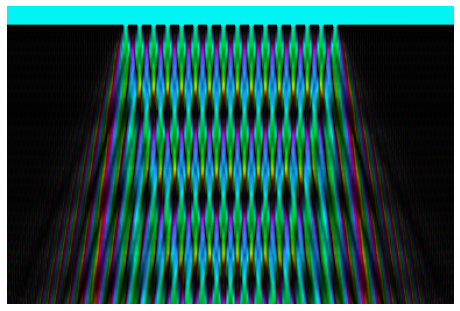

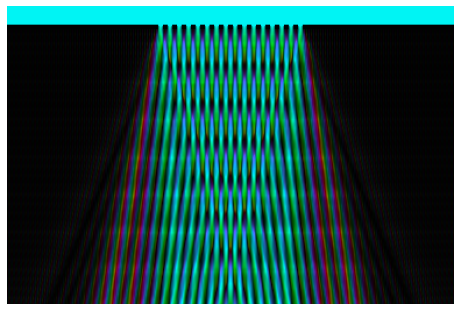

In [6]:
plot_image(color_complex(wavefunction_prop(
    make_diffraction_grating(gap_num=16, gap_spacing=16, gap_size = 4),
    normalize_rows_max=True)))

plot_image(color_complex(wavefunction_prop(
    make_diffraction_grating(gap_num=16, gap_spacing=12, gap_size = 4),
    normalize_rows_max=True)))

plot_image(color_complex(wavefunction_prop(
    make_diffraction_grating(gap_num=16, gap_spacing=8, gap_size = 4),
    normalize_rows_max=True)))